# Ciencia de datos aplicada

## Taller 8

### Contexto


Machine Learning with R by Brett Lantz is a book that provides an introduction to machine learning using R. As far as I can tell, Packt Publishing does not make its datasets available online unless you buy the book and create a user account which can be a problem if you are checking the book out from the library or borrowing the book from a friend. All of these datasets are in the public domain but simply needed some cleaning up and recoding to match the format in the book

Columns

1. age: age of primary beneficiary

2. sex: insurance contractor gender, female, male

3. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,objective index of body weight (kg / $m^2$) using the ratio of height to weight, ideally 18.5 to 24.9

4. children: Number of children covered by health insurance / Number of dependents

5. smoker: Smoking

6. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

7. charges: Individual medical costs billed by health insurance


### 1. Carga de librerías y archivos

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.optimize import linprog

In [2]:
# Leer los datos
data=pd.read_csv('insurance.csv')

In [3]:
data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [4]:
#Transformación de datos
data['smoker']=data['smoker'].apply(lambda x: 1 if x=='yes' else 0)
data=data.drop(['sex','region'],axis=1)

### 2. Análisis de sensibilidad

Los análisis de sensibilidad implican variar las entradas de un sistema para evaluar los impactos individuales de cada variable en la salida y, en última instancia, proporcionar información sobre los diferentes efectos de cada variable probada. Los análisis de sensibilidad se utilizan normalmente en una variedad de disciplinas, como en los negocios para el modelado financiero o en la ingeniería para optimizar la eficiencia en un sistema dado. Si se usa correctamente, el análisis de sensibilidad puede ser una herramienta poderosa para revelar información adicional que de otro modo se habría perdido.

Las sensibilidades de los inputs básicos a menudo se ignoran. La realización de un análisis de sensibilidad simple podría agregar valor a un proyecto de ciencia de datos al proporcionar información adicional a las partes interesadas para que tomen decisiones más informadas. Si bien la implementación de análisis de sensibilidad no sería factible o deseable para ciertas tareas, podrían servir como una herramienta exploratoria adicional para que los científicos de datos obtengan información adicional a partir de conjuntos de datos multivariados.

Se van a revisar datos sobre el:

* Precio
* Edad
* Número de hijos
* Índice de masa corporal
* y si la persona es fumadora

### 2.1. Correlación
Las matrices de coeficientes de correlación son a menudo la primera herramienta que se utiliza para determinar las relaciones entre variables. A continuación se muestra la matriz de coeficientes de correlación para los atributos.

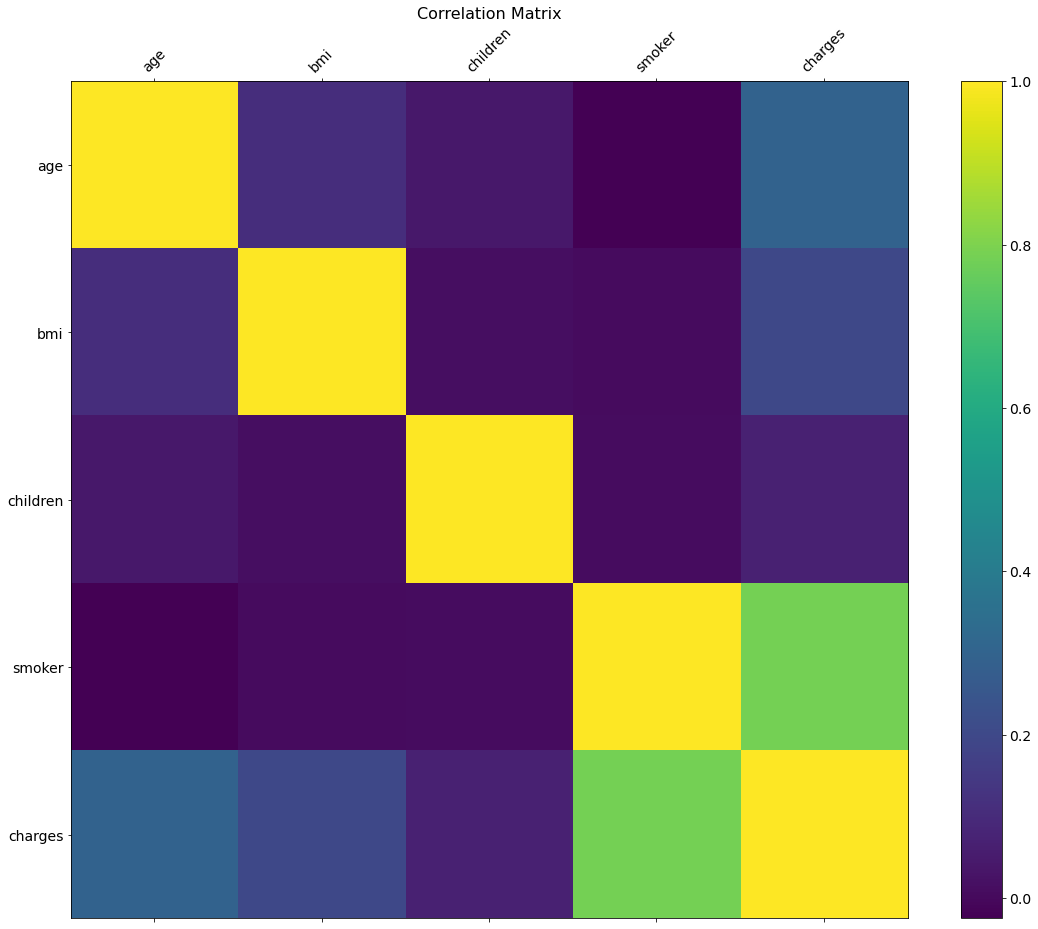

In [5]:
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [6]:
# Correlación
data.corr()

,age,bmi,children,smoker,charges
age,1.000000,0.109272,0.042469,-0.025019,0.299008
bmi,0.109272,1.000000,0.012759,0.003750,0.198341
children,0.042469,0.012759,1.000000,0.007673,0.067998
smoker,-0.025019,0.003750,0.007673,1.000000,0.787251
charges,0.299008,0.198341,0.067998,0.787251,1.000000


In [7]:
data.describe()

,age,bmi,children,smoker,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.204783,13270.422265
std,14.049960,6.098187,1.205493,0.403694,12110.011237
min,18.000000,15.960000,0.000000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,0.000000,9382.033000
75%,51.000000,34.693750,2.000000,0.000000,16639.912515
max,64.000000,53.130000,5.000000,1.000000,63770.428010


### 2.2. Una mirada más cercana a los datos para revelar información adicional

Podemos utilizar un diagrama de dispersión e implementar algunas técnicas de visualización multidimensional para comprender mejor cómo se relacionan los atributos. A continuación se muestra un diagrama de dispersión que muestra la relación entre el peso, el color y la claridad del diamante con el precio.

Text(0.5, 1.0, 'Grafico multidimensional de atributos')

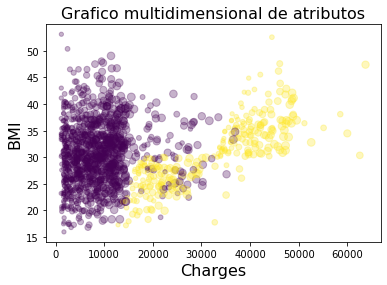

In [22]:
plt.scatter('charges', 'bmi',
             s='age',
             c='smoker',
             alpha=0.3, data=data)
plt.xlabel("Charges", size=16)
plt.ylabel("BMI", size=16)
plt.title("Grafico multidimensional de atributos", size=16)

### 2.3. Evaluación de sensibilidades de entrada en la salida
Normalmente, el enfoque más común es mantener todos los atributos en su valor medio mientras se varía solo una de las entradas para evaluar el efecto de cambiar solo una variable. Los análisis más avanzados podrían incluir la variación de múltiples entradas al mismo tiempo para estudiar el efecto combinado de múltiples variables.

En este ejemplo, variaremos un atributo a la vez en varios pasos para evaluar la sensibilidad general de cada variable. Agregar medio paso significa que estamos usando el valor del punto medio entre la media y el máximo para una sola variable y agregar un paso completo significa que usaremos el valor máximo para esa variable. La siguiente figura ilustra el concepto detrás del valor de la variable creciente y decreciente paso a paso desde la media hasta el máximo o mínimo.

In [23]:
data_summary=data.describe().transpose()[['mean','max','min']]
data_summary

,mean,max,min
age,39.207025,64.00000,18.0000
bmi,30.663397,53.13000,15.9600
children,1.094918,5.00000,0.0000
smoker,0.204783,1.00000,0.0000
charges,13270.422265,63770.42801,1121.8739


In [24]:
#Crear función para el cambio percentual
def cambios_percentuales(val,columna,valor):
    cambio=0
    if val=='min':
        cambio=-data[data[columna]==valor]['charges'].min()/data['charges'].mean()
    elif val=='max':
        cambio=data[data[columna]==valor]['charges'].max()/data['charges'].mean()
    else:
        cambio=0
    return cambio

In [25]:
#Encontrar los cambios percentuales del precio según el cambio en las variables
age=[cambios_percentuales(i,'age',data_summary.loc['age',i]) for i in ['min','mean','max']]
bmi=[cambios_percentuales(i,'bmi',data_summary.loc['bmi',i]) for i in ['min','mean','max']]
smoke=[cambios_percentuales(i,'smoker',data_summary.loc['smoker',i]) for i in ['min','mean','max']]

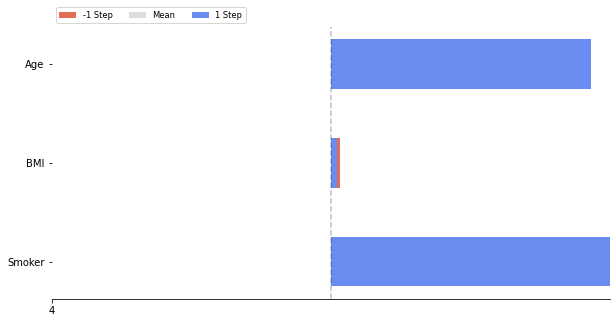

In [26]:
import numpy as np
import matplotlib.pyplot as plt


category_names = ['-1 Step', 'Mean','1 Step']
results = {
    'Age': age,
    'BMI': bmi,
    'Smoker': smoke,
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1]//2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    ax.set_xlim(-4, 4)
    ax.set_xticks(np.arange(-4, 4, 10))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Ledgend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')

    return fig, ax


fig, ax = survey(results, category_names)
plt.show()


In [27]:
bmi

[-0.1277123188801528, 0, 0.08767337442277054]

In [28]:
age

[-0.08453942742628004, 0, 3.7359521354667513]

In [29]:
smoke

[-0.08453942742628004, 0, 4.805455827695261]

<BarContainer object of 3 artists>

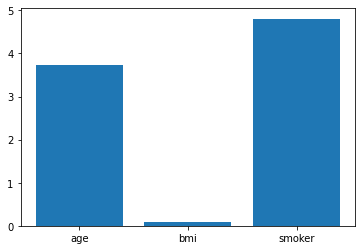

In [30]:
# Create bars
plt.bar(['age','bmi','smoker'], [age[2],bmi[2],smoke[2]])

### 2.4. ¿Qué pasaría si?
Un análisis hipotético se usa comúnmente para modelar cómo el cambio de variables específicas afecta el resultado. Tenga en cuenta que este es más un enfoque de modelado hacia adelante porque es independiente del conjunto de datos.

In [31]:
x=data.drop(['children','charges'],axis=1)
y=data['charges']

In [32]:
x

,age,bmi,smoker
0,19,27.900,1
1,18,33.770,0
2,28,33.000,0
3,33,22.705,0
4,32,28.880,0
...,...,...,...
1333,50,30.970,0
1334,18,31.920,0
1335,18,36.850,0
1336,21,25.800,0


In [33]:
modelo = LinearRegression()
modelo= LinearRegression().fit(x, y)

In [34]:
modelo.coef_

array([  259.54749155,   322.61513282, 23823.68449531])

In [35]:
def funcion_cargos(age,bmi,smoke):
    cargo=modelo.coef_[0]*age+modelo.coef_[1]*bmi+smoke*modelo.coef_[2]
    return cargo

In [36]:
# restricciones
ager=[18,100]
bmir=[15,53]
smoke=[0,1]

### 3. Análisis sensitividad en python
Implementaciones en Python de los métodos de análisis de sensibilidad de uso común, incluidos los métodos Sobol, Morris y FAST. Útil en el modelado de sistemas para calcular los efectos de las entradas del modelo o los factores exógenos en las salidas de interés.

In [37]:
# Crear la función
def ET(X):
    return(0.0031*X[:,0]*(X[:,1]+209)*(X[:,2]*(X[:,2]+15))**-1)

In [45]:
# Definir el problema
problem = {'num_vars': 3,
           'names': ['C', 'R', 't'],
           'bounds': [[10, 100],
                     [3, 7],
                     [-10, 30]]
           }

In [46]:
# Generar muestras
muestras = saltelli.sample(problem, 1000, calc_second_order=False)

In [47]:
# Correr el modelo con las muestras
Y = ET(muestras)

In [48]:
# Perform analysis
Salida = sobol.analyze(problem, Y, print_to_console=True)

         ST    ST_conf
C  0.940600  11.528769
R  0.203185   1.410563
t  1.082769  12.362189
         S1   S1_conf
C  0.001239  0.018619
R -0.000272  0.021138
t  0.001727  0.037308
              S2   S2_conf
(C, R)  0.032187  0.235276
(C, t)  0.773123  8.667878
(R, t)  0.149555  1.554847


In [49]:
Salida.to_df()

[         ST    ST_conf
 C  0.940600  11.528769
 R  0.203185   1.410563
 t  1.082769  12.362189,
          S1   S1_conf
 C  0.001239  0.018619
 R -0.000272  0.021138
 t  0.001727  0.037308,
               S2   S2_conf
 (C, R)  0.032187  0.235276
 (C, t)  0.773123  8.667878
 (R, t)  0.149555  1.554847]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

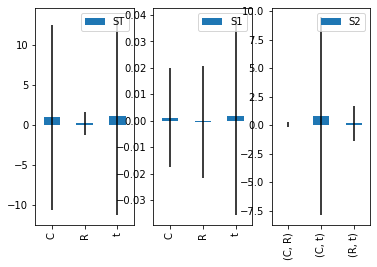

In [50]:
Salida.plot()

### Extensión

1. Realice el análisis de sensitividad con python para la función  $y = a + x^2$
2. Busque en grupo una solución al siguiente problema:
    * En un hospital un grupo de enfermos en recuperación debe llevar una dieta especial, el cual debe tener ciertos índices calóricos por la complejidad de su enfermedad, además alimentos ricos en vitaminas y minerales específicos para una pronta recuperación, esta dieta se debe componer de carne, papas, habichuela, leche y guayaba. Los precios por kilo son 700, 80, 250, 70 y 80 respectivamente. Este selecto grupo de enfermos se compone de 6 personas y cada persona debe consumir 800 calorías. Para que la alimentación sea adecuada se debe componer de 20% de proteinas, 30% de grasas y 50% de glúcidos, para facilitar el trabajo se tiene la siguiente tabla
    
|             | Proteinas | Grasas | Glúcidos |
|:-----------:|:---------:|:------:|:--------:|
|    Carne    |     10    |   10   |     0    |
|    Papas    |     2     |    0   |    20    |
| Habichuelas |     1     |    0   |     5    |
|    Leche    |     5     |    3   |     5    |
|   Guayaba   |     1     |    0   |    15    |

### Análisis de sensibilidad

Se trata de una función $f(x) = y$. La variable de respuesta es $y$ y la variable independiente $x$. La función tiene un parámetro $a$, para el cual ejecutaremos el análisis de sensibilidad.

Acotamos los valores posibles de $a$ entre -50 y 50.

In [ ]:
# Pending

### Programación lineal

#### Conjuntos

$A$: conjunto de alimentos.

$$
    A = \{\text{Carne}, \text{Papas}, \text{Habichuelas}, \text{Leche}, \text{Guayaba}\}
$$

$N$: conjunto de tipos de calorías.

$$
    N = \{\text{Proteinas}, \text{Grasas}, \text{Glúcidos}\}
$$

#### Parámetros

$c_{a}$: costo por kilo de cada alimento $a \in A$.

$$
c_{a}=\begin{cases} 
      700 & a = \text{Carne}\\
      80 & a = \text{Papas}\\
      250 & a = \text{Habichuelas}\\
      70 & a = \text{Leche}\\
      80 & a = \text{Guayaba}
\end{cases}
$$

$k_{a,n}$: cantidad de calorías que aporta un kilo del alimento $a \in A$ de tipo calórico $n \in N$.

Omitimos la declaración explícita de este parámetro ya que está declarado en el enunciado.

$f_{n}$: porcion de las calorías tipo $n\in N$ que deben constituir una comida.

$$
f_{n}=\begin{cases} 
      0.2 & a = \text{Proteinas}\\
      0.3 & a = \text{Grasas}\\
      0.5 & a = \text{Glúcidos}
\end{cases}
$$

$\text{cal}$: cantidad de calorías en una comida.

$$
    \text{cal} = 800
$$

$\text{per}$: cantidad de pacientes.

$$
    \text{per} = 6
$$

#### Variables

$x_{a}$: cantidad de kilos a utilizar del alimento $a\in A$.

#### Función objetivo

$$
    \min_{x_{a},\forall a \in A}\sum_{a\in A}c_{a}\cdot x_{a}
$$

#### Restricciones

Garantizamos que del total de calorías, se cumpla la porción de cada tipo $n\in N$.

$$
    \sum_{a\in A} k_{a,n}\cdot x_{a} \geq f_{n} \cdot \text{per} \cdot \text{cal},\ \forall n\in N.
$$

Nos aeguramos de que las variables sean siempre positivas.
$$
    x_{a} \geq 0, \ \forall a \in A.
$$

In [67]:
# Declaramos los conjuntos del problema.
Am = {'Carne', 'Papas', 'Habichuelas', 'Leche', 'Guayaba'} # Conjunto de alimentos.
Nm = {'Proteinas', 'Grasas', 'Glúcidos'} # Conjunto de tipos de calorías.

# Declaramos los parámetros del problema.
cm = {'Carne': 700,
      'Papas': 80,
      'Habichuelas': 250,
      'Leche': 70,
      'Guayaba': 80} # Costo por kilo de cada alimento a in A

km = {('Carne',      'Proteinas'): 10, ('Carne',       'Grasas'): 10, ('Carne',       'Glúcidos'): 0,
     ('Papas',       'Proteinas'): 2,  ('Papas',       'Grasas'): 0,  ('Papas',       'Glúcidos'): 20,
     ('Habichuelas', 'Proteinas'): 1,  ('Habichuelas', 'Grasas'): 0,  ('Habichuelas', 'Glúcidos'): 5,
     ('Leche',       'Proteinas'): 5,  ('Leche',       'Grasas'): 3,  ('Leche',       'Glúcidos'): 5,
     ('Guayaba',     'Proteinas'): 1,  ('Guayaba',     'Grasas'): 0,  ('Guayaba',     'Glúcidos'): 15} # Cantidad de calorías de tipo n in N que aporta el alimento a in A.

fm = {'Proteinas': 0.2,
      'Grasas': 0.3,
      'Glúcidos': 0.5} # Porcion de las calorias totales que deben ser de tipo n in N.

calm = 800 # Cantidad de calorias en una comida

perm = 6 # Cantidad de pacientes

In [100]:
# Construimos los parámetros de la función linprog.

c = np.array([*cm.values()]) # Costos de la FO.

A = np.matrix([[k[(a,n)] for a in Am] for n in Nm]) # Matriz de coeficientes

b = np.array([int(round(f[n] * perm * calm, 0)) for n in Nm]) # RHS de las otras restricciones.

bounds = np.array([(0, None) for a in Am])

In [116]:
# Construimos y resolvemos el modelo.
res = linprog(c=c, # Función de costo.
              A_ub=-A, #Matriz
              b_ub=-b, #Coeficientes libres
              bounds=bounds, #límites de x              
              method="revised simplex") #método

print(res)

     con: array([], dtype=float64)
     fun: 22720.0
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([  0., 640.,   0.])
  status: 0
 success: True
       x: array([  0., 144.,   0., 160.,   0.])


Podemos ver que la comida ideal que garantiza una dieta balanceada y minimiza los costos del hospital contiene únicamente papas y leche. El costo total es de $22720.